In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'w'
from astropy import log, constants, coordinates, units as u
import warnings
warnings.filterwarnings('ignore')
log.setLevel('ERROR')

# My functions
from mol_model import fetch_cubes, model_and_plot, list_mol_tags, get_cubes_from_mask, plot_mom0s

results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/contsub_smoothed_cubes_K/'

make: *** No targets specified and no makefile found.  Stop.


In [2]:
# Get list of all cubes
import glob
cubefns = glob.glob(f"{results}/source_ab_*.image.commonbeam.contsub.K.fits")

In [3]:
# Set coordinate of central source
crd = coordinates.SkyCoord("17:46:10.6339473267 -28:42:17.9807702398", frame='icrs', unit=(u.h, u.deg))

In [4]:
# Get only the cubes that have our line of interest in them
mol_tag = 29005 # 29506
cubes, tbl = fetch_cubes(cubefns, catalog='JPL', mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, parse_loc=False, ret_tbl=True)

Beam: BMAJ=1.4511224478058344 arcsec BMIN=1.283357392336026 arcsec BPA=112.6334681915826 deg
[<Table length=3>
  FREQ     ERR    LGINT    DR    ELO    GUP   TAG   QNFMT QN'  QN" 
  MHz      MHz   MHz nm2        1 / cm                             
float64  float64 float64 int64 float64 int64 int64  int64 str3 str3
-------- ------- ------- ----- ------- ----- ------ ----- ---- ----
93171.88    0.04 -2.7844     2     0.0     9 -29005   102  1 1  0 1
 93173.7    0.04 -2.5625     2     0.0    15 -29005   102  1 2  0 1
93176.13    0.22 -3.2614     2     0.0     3 -29005   102  1 0  0 1]

*** NOTE: Make sure you are capturing the cubes and tables into different variables!


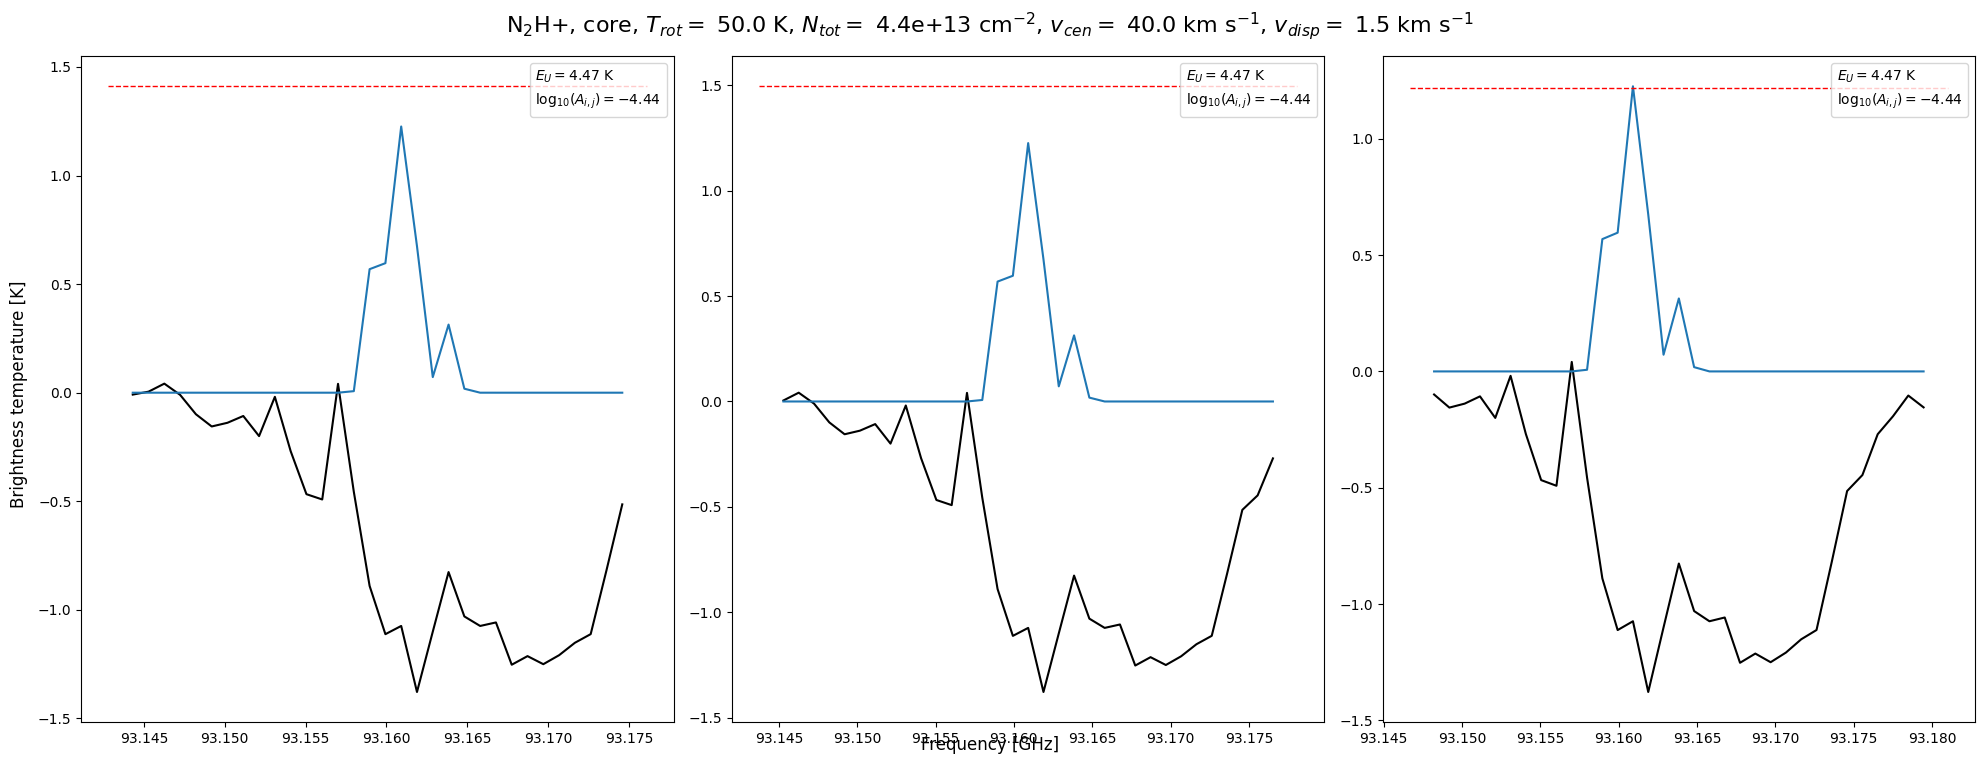

In [20]:
# Generate the model and plot the model and data spectra
model_and_plot(cubes, temp = 50., N_tot = 4.4e+13, v_cen = 40.*u.km/u.s, v_disp = 1.5*u.km/u.s,
               mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, catalog='JPL', fig_width=20, fig_height=8, 
               nrows=1, ncols=3, parse_loc=False, line_by_line=True, name_for_plot=f'N$_2$H$+$', 
               extr_type="coord", crd=crd, show_2_sigma=True)

In [11]:
# Get subcubes based on mask
cubes_masked = get_cubes_from_mask("diffuse_regions.fits", 1, cubes, plot_region=False)

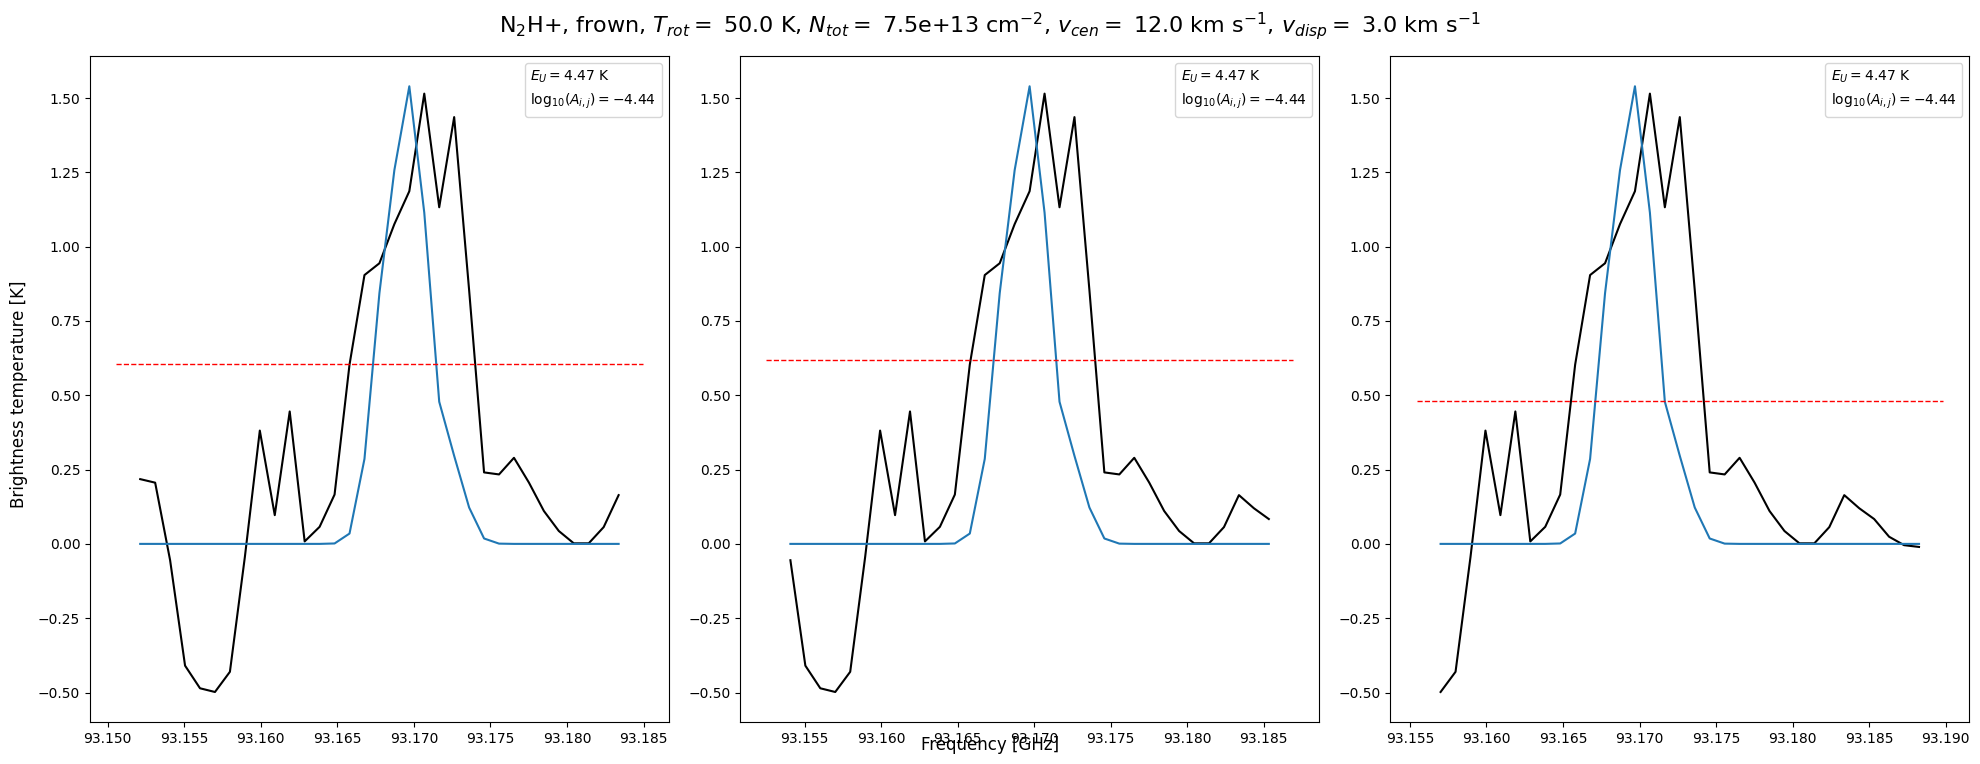

In [26]:
# Generate the model and plot the model and data spectra
freqs = model_and_plot(cubes_masked, temp = 50., N_tot = 7.5e+13, v_cen = 12.*u.km/u.s, v_disp = 3.*u.km/u.s,
                       mol_name_pyspeckit=None, mol_tag_pyspeckit=mol_tag, catalog='JPL', fig_width=20, fig_height=8, 
                       nrows=1, ncols=3, parse_loc=False, line_by_line=True, name_for_plot=f'N$_2$H$+$', 
                       extr_type="reg", return_freqs=True, show_2_sigma=True)

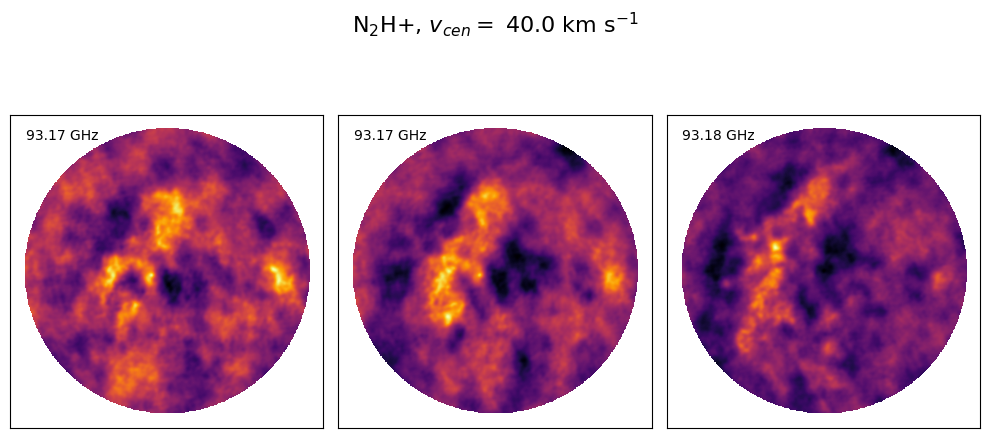

In [8]:
# Plot moment maps
plot_mom0s(cubes, freqs, v_cen=40*u.km/u.s, fig_width=10, fig_height=5, nrows=1, ncols=3, name_for_plot=f'N$_2$H$+$')

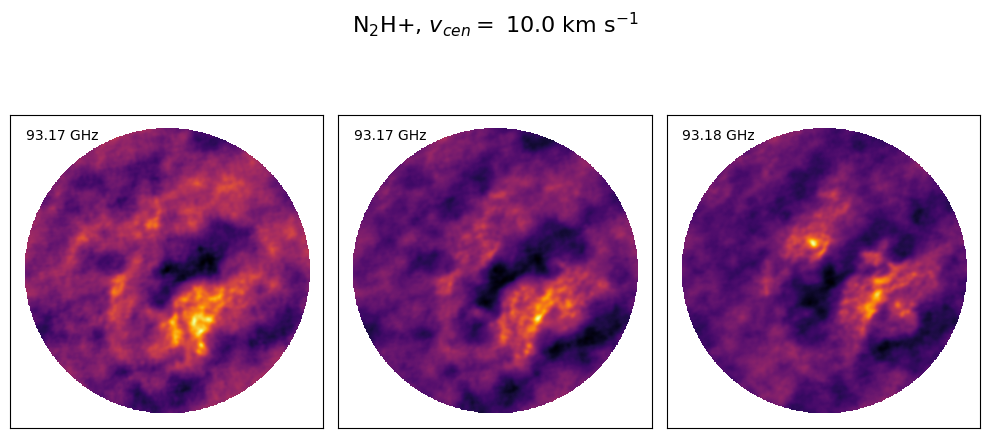

In [9]:
# Plot moment maps
plot_mom0s(cubes, freqs, v_cen=10*u.km/u.s, fig_width=10, fig_height=5, nrows=1, ncols=3, name_for_plot=f'N$_2$H$+$')

In [6]:
from spectral_cube import SpectralCube
import dask
dask.config.set(scheduler = 'threads', num_workers = 8)
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
destination = '/blue/adamginsburg/abulatek/brick/first_results/'

In [36]:
fn_cube = 'source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image'
fn_pb = 'source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.pb'
# fn_cube_cb = 'source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image.commonbeam.fits'

In [40]:
cube = SpectralCube.read(results+fn_cube, format='casa_image', use_dask=True)
pb = SpectralCube.read(results+fn_pb, format='casa_image', use_dask=True)
## Use division to correct the cube, and deal with the units issue
cube_pbcor = cube.unitless/(pb.unitless)
cube_pbcor_unit = cube_pbcor * (u.Jy/u.beam)
cube_common_beam = cube_pbcor_unit.beams.common_beam(max_iter = 20, max_epsilon = 0.01)
smoothed_cube = cube_pbcor_unit.convolve_to(cube_common_beam) # Convert from VaryingResolution to regular
smoothed_cube.allow_huge_operations=True
smoothed_cube_K = smoothed_cube.to(u.K) # Convert to K
# Write cube to disk
smoothed_cube_K.write(destination+'source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.pbcor.image.K.fits', format='fits')

In [7]:
# Test to make sure the cube is how you want it
testcube = SpectralCube.read(destination+'source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.pbcor.image.K.fits', use_dask = True)
print(testcube) # Should be DaskSpectralCube with unit=K

DaskSpectralCube with shape=(1920, 512, 512) and unit=K and chunk size (240, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 91425792724.639 Hz:93299566513.404 Hz


In [8]:
noise_map = testcube.mad_std(axis=0, ignore_nan=True)

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = 

In [46]:
np.nanmin(noise_map)

<Projection 0.06308846 K>

In [101]:
realcube_pth = '/blue/adamginsburg/abulatek/brick/symlinks/contsub_smoothed_cubes_K/source_ab_93_spw27_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image.commonbeam.contsub.K.fits'
realcube = SpectralCube.read(realcube_pth, use_dask = True)
print(realcube) # Should be DaskSpectralCube with unit=K

DaskSpectralCube with shape=(1920, 512, 512) and unit=K and chunk size (240, 128, 128):
 n_x:    512  type_x: RA---SIN  unit_x: deg    range:   266.528130 deg:  266.560501 deg
 n_y:    512  type_y: DEC--SIN  unit_y: deg    range:   -28.719152 deg:  -28.690763 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 91425792724.639 Hz:93299566513.404 Hz


In [100]:
# realnoise_map = realcube.mad_std(axis=0, ignore_nan=True)
# np.nanmin(realnoise_map)

In [110]:
realcube.beam

Beam: BMAJ=1.4511224478058344 arcsec BMIN=1.283357392336026 arcsec BPA=112.6334681915826 deg

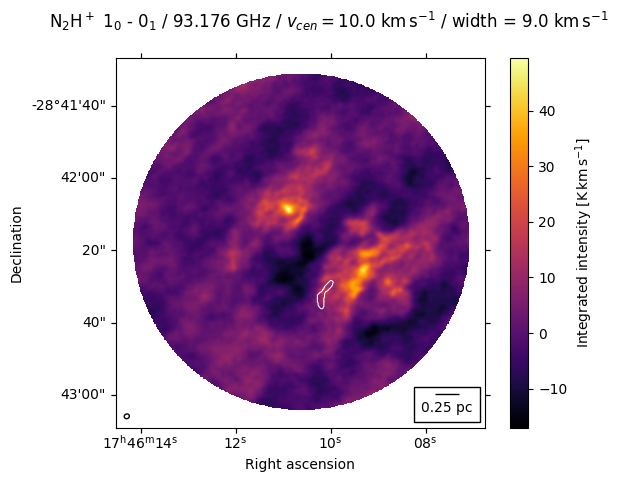

In [114]:
v_half=4.5
v_cen=10*u.km/u.s
freq = (93176.13*u.MHz).to(u.GHz)

ax = plt.subplot(111, projection = realcube[0].wcs)
plt.suptitle(f"N$_2$H$^+$ 1$_0$ - 0$_1$ / {freq:0.3f} / $v_{{cen}} = {v_cen.value}$ {v_cen.unit.to_string(format = 'latex_inline')} / width = {v_half*2} {v_cen.unit.to_string(format = 'latex_inline')}")
molcube_slice = realcube.with_spectral_unit(unit=u.km/u.s, velocity_convention='radio', 
                                           rest_value=freq).spectral_slab(v_cen - v_half*u.km/u.s, v_cen + v_half*u.km/u.s)
mom0 = molcube_slice.moment0()
immin = np.nanmin(mom0.value)
immax = np.nanmax(mom0.value)
im = ax.imshow(mom0.value, origin='lower', cmap='inferno', vmax=immax, vmin=immin)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Integrated intensity [{mom0.unit.to_string(format = 'latex_inline')}]")
ax.set_ylabel('Declination')
ax.set_xlabel('Right ascension')
# Add frown contour
diffreg = fits.open('diffuse_regions.fits')
diffreg_mask = diffreg[0].data == 1
array, footprint = reproject_interp((diffreg_mask, diffreg[0].header), noise_map.wcs.celestial, shape_out=(noise_map.shape[0], noise_map.shape[1]))
mask = array == 1
ax.contour(mask, levels = [0, 1], linewidths=0.75, colors = ['w'])
# Put beam on each image
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(noise_map.wcs)**0.5*u.deg).to(u.arcsec))
bm = noise_map.beam
bmell = bm.ellipse_to_plot(15, 15, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
ax.add_artist(bmell)
# Compute the angle corresponding to 1 pc at the distance of the galactic center
from astropy.visualization.wcsaxes import add_scalebar
gc_distance = 8.0*u.kpc
scalebar_length = 0.25*u.pc
scalebar_angle = (scalebar_length / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())
# Add a scale bar
add_scalebar(ax, scalebar_angle, label="0.25 pc", color="black", frame=True)
plt.show()

In [115]:
molcube_slice.mad_std()

calculations.  This may result in slow computation. [spectral_cube.dask_spectral_cube]


<Quantity 0.46838255 K>

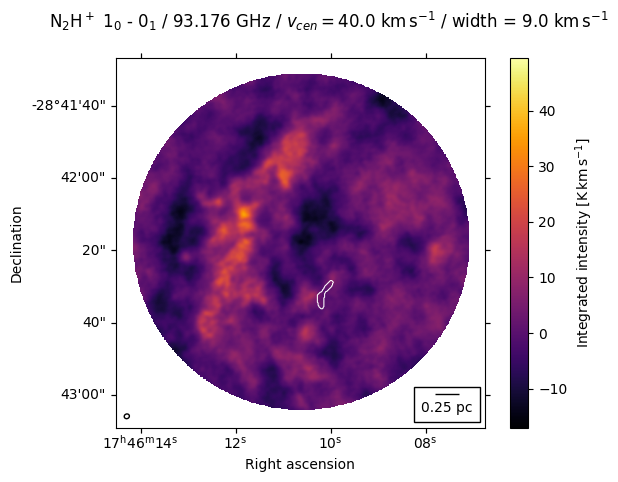

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from reproject import reproject_interp
from astropy import coordinates, wcs, units as u

v_half=4.5
v_cen=40*u.km/u.s
freq = (93176.13*u.MHz).to(u.GHz)

ax = plt.subplot(111, projection = realcube[0].wcs)
plt.suptitle(f"N$_2$H$^+$ 1$_0$ - 0$_1$ / {freq:0.3f} / $v_{{cen}} = {v_cen.value}$ {v_cen.unit.to_string(format = 'latex_inline')} / width = {v_half*2} {v_cen.unit.to_string(format = 'latex_inline')}")
molcube_slice = realcube.with_spectral_unit(unit=u.km/u.s, velocity_convention='radio', 
                                           rest_value=freq).spectral_slab(v_cen - v_half*u.km/u.s, v_cen + v_half*u.km/u.s)
mom0 = molcube_slice.moment0()
im = ax.imshow(mom0.value, origin='lower', cmap='inferno', vmax=immax, vmin=immin)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(f"Integrated intensity [{mom0.unit.to_string(format = 'latex_inline')}]")
ax.set_ylabel('Declination')
ax.set_xlabel('Right ascension')
# Add frown contour
diffreg = fits.open('diffuse_regions.fits')
diffreg_mask = diffreg[0].data == 1
array, footprint = reproject_interp((diffreg_mask, diffreg[0].header), noise_map.wcs.celestial, shape_out=(noise_map.shape[0], noise_map.shape[1]))
mask = array == 1
ax.contour(mask, levels = [0, 1], linewidths=0.75, colors = ['w'])
# Put beam on each image
pixscale = np.abs((wcs.utils.proj_plane_pixel_area(noise_map.wcs)**0.5*u.deg).to(u.arcsec))
bm = noise_map.beam
bmell = bm.ellipse_to_plot(15, 15, pixscale)
bmell.set_facecolor('none')
bmell.set_edgecolor('k')
ax.add_artist(bmell)
# Compute the angle corresponding to 1 pc at the distance of the galactic center
from astropy.visualization.wcsaxes import add_scalebar
gc_distance = 8.0*u.kpc
scalebar_length = 0.25*u.pc
scalebar_angle = (scalebar_length / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())
# Add a scale bar
add_scalebar(ax, scalebar_angle, label="0.25 pc", color="black", frame=True)
plt.show()

In [117]:
molcube_slice.mad_std()

calculations.  This may result in slow computation. [spectral_cube.dask_spectral_cube]


<Quantity 0.49740893 K>